In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, pairwise_distances

# Load data

In [2]:
df = pd.read_csv('../../data/raw/anime_songs.csv')

## Data exploration

In [3]:
display(df.shape)
display(df.head(3))

(438, 20)

,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,name
0,0,0.627,0.824,1,-3.419,1,0.1180,0.0699,0.000066,0.3100,0.774,169.935,audio_features,06XQvnJb53SUYmlWIhUXUi,spotify:track:06XQvnJb53SUYmlWIhUXUi,https://api.spotify.com/v1/tracks/06XQvnJb53SU...,https://api.spotify.com/v1/audio-analysis/06XQ...,206000,4,怪物
1,0,0.585,0.910,5,-3.703,0,0.0917,0.0138,0.000000,0.1900,0.602,92.591,audio_features,5MVjxslIF7mVtYo75Nk445,spotify:track:5MVjxslIF7mVtYo75Nk445,https://api.spotify.com/v1/tracks/5MVjxslIF7mV...,https://api.spotify.com/v1/audio-analysis/5MVj...,221426,4,廻廻奇譚
2,0,0.561,0.667,8,-8.519,0,0.0652,0.0539,0.000000,0.0797,0.383,100.047,audio_features,3CYfCp9XAHc69wtCKTwMaj,spotify:track:3CYfCp9XAHc69wtCKTwMaj,https://api.spotify.com/v1/tracks/3CYfCp9XAHc6...,https://api.spotify.com/v1/audio-analysis/3CYf...,217807,4,0 (zero)


In [4]:
df.columns

Index(['Unnamed: 0', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'id', 'uri', 'track_href', 'analysis_url',
       'duration_ms', 'time_signature', 'name'],
      dtype='object')

## Choose useful columns

In [72]:
useful_cols = ['danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness',
        'liveness','valence', 'tempo']
df_anime = df[useful_cols]

In [73]:
# conduct scaling on numerical columns
std_scale = StandardScaler()
df_num = df_anime.select_dtypes(exclude=['object','category'])
df_num = pd.DataFrame(std_scale.fit_transform(df_num),
                      columns = df_num.columns)

# combine the numerical columns with the "name" column
df_scale = pd.concat([df_num],axis=1)

In [74]:
df_scale.shape

(438, 9)

# Modeling

In [75]:
def get_models_dict(df, cols, K_range, seed=42, return_list=False):
    """
    run several K-means models with different number of clusters K on a dataframe
    df: dataframe to work on
    cols: features to include in the K-Means algorithm
    K_range: range of number of clusters to try
    """
    
    model_dict = {}
    for k in K_range:
        mod = KMeans(n_clusters=k, random_state=seed).fit(df[cols])
        model_dict[str(k)] = mod
    res = model_dict
    
    if return_list:
        ls_mods = list(model_dict.values())
        res = (model_dict, ls_mods)
    return res

In [76]:
def plot_models_performance(df, cols, mod_list, K_range):
    """
    Plot silhoutte 
    """
    within_ss = [i.inertia_ for i in mod_list]
    silhouette_list = [silhouette_score(df[cols], i.labels_) for i in mod_list]
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    axs[0].plot(K_range, within_ss, color='red')
    axs[1].plot(K_range, silhouette_list, color='orange')
    
    for i in range(2): 
        axs[i].set_xlabel('number of clusters')
    for idx, name in zip([0,1,2], ['inertia', 'silhouette score']): 
        axs[idx].set_ylabel(name)
    
    plt.show()

In [77]:
K_range = range(3,10)
cols_to_train = df_scale.columns
mods_dict, mods_ls = get_models_dict(df_scale,cols=cols_to_train,
                                     K_range=K_range,return_list=True)

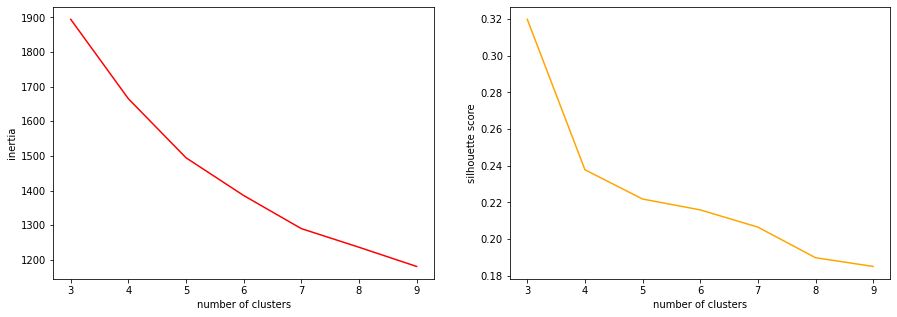

In [78]:
plot_models_performance(df_scale,cols=cols_to_train,
                        mod_list=mods_ls, K_range=K_range)

In [67]:
K_final = 5
final_model = mods_dict[str(K_final)]

In [114]:
### write the clustering result to a csv file
df_new = pd.concat([df,
                    pd.Series(final_model.labels_,name="clusterId")],axis=1)

In [115]:
mapper = {"name":"title",
         "duration_ms":"duration",
         "uri":"track_uri"}
cols_to_drop = ['mode','type','id','track_href','analysis_url',
                'time_signature','Unnamed: 0']
df_new = df_new.drop(cols_to_drop,axis=1).rename(columns=mapper)

In [116]:
df_new.to_csv("../../data/intermediate/clustered_songs.csv",index=False)

## Clustering results

In [83]:
def summary_kmeans(df, model):
    """
    Returns a dataframe containing cluster summary information
    """
    df_clusters = pd.DataFrame(model.cluster_centers_, columns=list(df.columns))
    df_clusters['count'] = pd.Series(model.labels_).value_counts().sort_index()
    df_clusters['percent'] = df_clusters['count']/df_clusters['count'].sum()
    columns_ordered = ['count', 'percent'] + list(df.columns)
    df_clusters = df_clusters[columns_ordered]
    return df_clusters

In [84]:
summary_kmeans(df_scale,final_model)

,count,percent,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,35,0.079909,0.410109,1.237692,0.917216,2.680120,-0.988510,-0.857344,0.810967,0.703986,0.763515
1,120,0.273973,-1.171732,-0.896628,-0.837243,-0.515586,0.783719,0.721438,-0.301767,-1.005992,-0.514985
2,131,0.299087,0.548181,0.675404,0.776819,-0.351635,-0.716967,-0.841925,-0.386036,0.591590,0.038882
3,91,0.207763,0.447652,-0.999343,-0.989514,0.227515,1.045278,1.185355,-0.421290,-0.301340,0.099108
4,61,0.139269,0.224689,1.094072,0.928674,-0.107765,-0.994198,-0.887552,1.585840,0.754151,0.343651


In [89]:
def summary_plot(df, model):
    df_summary = summary_kmeans(df, model)
    x_max = df_summary.iloc[:,2:].values.max()
    x_min = df_summary.iloc[:,2:].values.min()
    
    fig, axs = plt.subplots(nrows=1, ncols=model.n_clusters, figsize=(25,5))
    for i in range(model.n_clusters):
        if i > 0:
            axs[i].get_yaxis().set_ticklabels([])
        axs[i].scatter(x=df_summary.iloc[i, 2:].values, y=list(df.columns), color='royalblue')
        axs[i].set_xlabel(f'cluster{str(i)}')
        axs[i].set_xlim(x_min-0.5, x_max+0.5)
    plt.show()

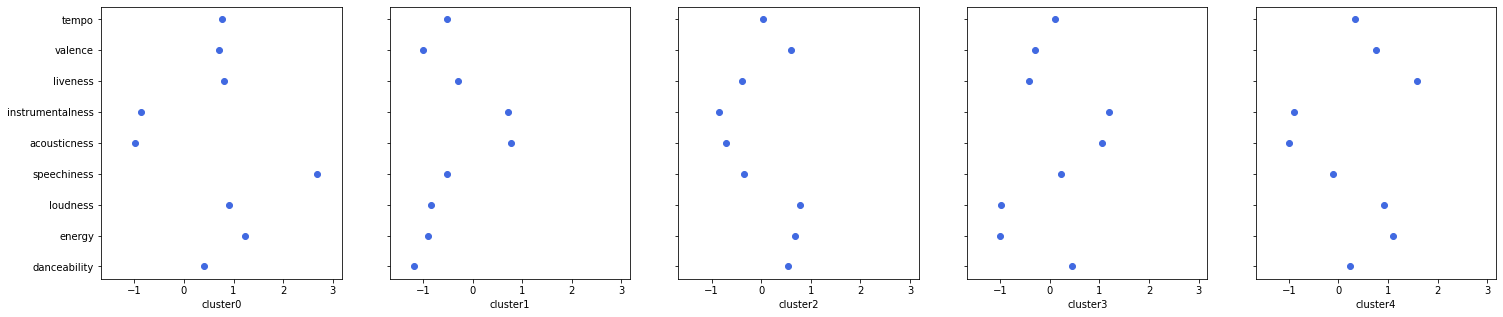

In [90]:
summary_plot(df_scale,final_model)